# Imports, helper functions, configuration settings

In [1]:
# Standard library imports
import pickle

# Local imports
from config import (
    MODEL,
    EPOCHS,
    SLIDER_LENGTH,
    LEARNING_RATE,
    RUN_ID_MS,
    INPUT_LIST,
    VARIABLE,
)
from data import (
    normalize_data,
    calculate_mean_std,
    apply_normalization,
    merge_training_data,
)
from tools import (
    train_single_model,
    format_predictions,
    train_model_k_fold,
    make_model_predictions,
    generate_all_predictions,
    calculate_rmse,
    calculate_spatial_rmse,
    calculate_global_rmse,
)
from models import (
    CNNModel,
    ResNet18,
)
from plotting import (
    plot_training_loss,
    global_timeseries_plot,
    global_anomaly_plot,
)

# Data Formatting

In [2]:
# 3 EM average:
file_path = "/discover/nobackup/jmekus/loaded_DT_data_EMavg.pkl"
with open(file_path, "rb") as f:
    loaded_data = pickle.load(f)
    
# Retrieve the lists from the loaded data
X_train = loaded_data["X_train"]
X_test = loaded_data["X_test"]
Y_train = loaded_data["Y_train"]
Y_test = loaded_data["Y_test"]

# Normalize Input Data
meanstd_inputs = calculate_mean_std(X_train, INPUT_LIST)
X_train_norm, X_test_xr = apply_normalization(
    X_train, X_test, meanstd_inputs, INPUT_LIST
)

# Reshape input/output for training
X_train_all, Y_train_all = merge_training_data(
    X_train, Y_train, X_train_norm, VARIABLE, SLIDER_LENGTH
)
print(f"X_train dimensions: {X_train_all.shape}")
print(f"Y_train dimensions: {Y_train_all.shape}")

X_train dimensions: (832, 90, 144, 10)
Y_train dimensions: (832, 90, 144)


# Model Training

100%|██████████| 150/150 [03:08<00:00,  1.26s/it]


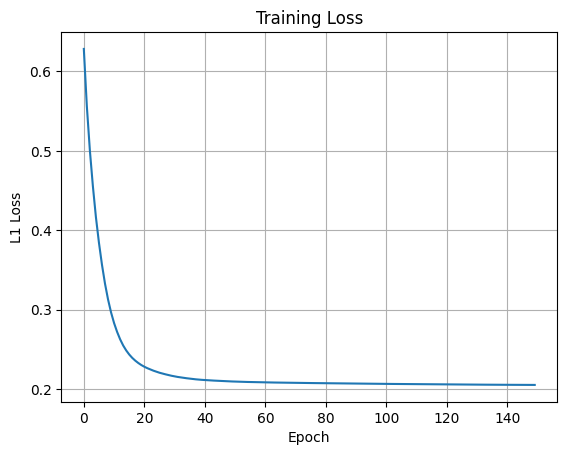

In [3]:
# Set model
input_channels = len(INPUT_LIST)
output_channels = len(VARIABLE)
if MODEL == 'CNN':
    model = CNNModel(input_channels, output_channels)
elif MODEL == 'RESNET':
    model = ResNet18(input_channels, output_channels)
    
# Train model
model, all_train_losses = train_model_k_fold(
    X_train_all, Y_train_all, model, INPUT_LIST, VARIABLE, LEARNING_RATE, EPOCHS
)

# Plot training curve
plot_training_loss(all_train_losses, EPOCHS)

# Model Predictions

In [4]:
# Make predictions on 126/245/585
(
    Y_pred,
    Y_test,
    Y_pred_585,
    Y_test_585,
    Y_pred_126,
    Y_test_126,    
) = generate_all_predictions(
    X_test,
    Y_test,
    X_train,
    Y_train,
    model,
    meanstd_inputs,
    SLIDER_LENGTH,
    RUN_ID_MS,
    VARIABLE,
    INPUT_LIST,
)

# Evaluation

In [5]:
# Calculate RMSE for 126/245/585
rmse_245 = calculate_rmse(Y_pred, Y_test, VARIABLE)
rmse_126 = calculate_rmse(Y_pred_126, Y_test_126, VARIABLE)
rmse_585 = calculate_rmse(Y_pred_585, Y_test_585, VARIABLE)
print("Standard RMSE:")
print(f"    SSP245: {rmse_245}")
print(f"    SSP126: {rmse_126}")
print(f"    SSP585: {rmse_585}")

# Calculate spatial and global RMSE
spatial_RMSE = calculate_spatial_rmse(Y_pred, Y_test, VARIABLE)
global_RMSE = calculate_global_rmse(Y_pred, Y_test, VARIABLE)
print(f'\nSpatial RMSE: {spatial_RMSE}')
print(f'\nGlobal  RMSE: {global_RMSE}')

Standard RMSE:
    SSP245: 0.4037000834941864
    SSP126: 0.3908170759677887
    SSP585: 0.3983026444911957

Spatial RMSE: 0.1515999287366867

Global  RMSE: 0.038319796323776245


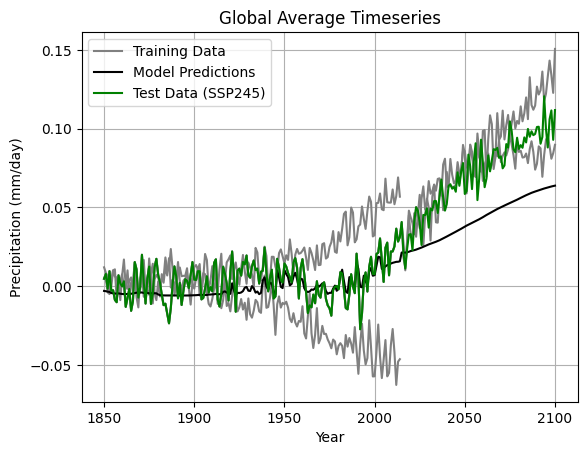

In [6]:
# Plot timeseries
global_timeseries_plot(Y_pred=Y_pred, Y_train=Y_train, Y_test=Y_test, VARIABLE=VARIABLE)

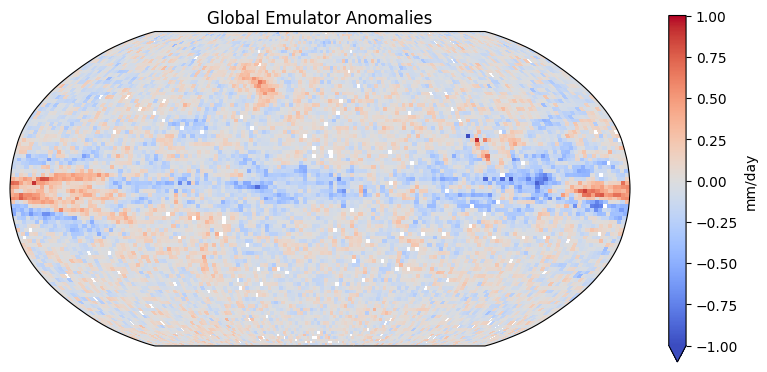

In [7]:
# Plot spatial anomalies
global_anomaly_plot(Y_pred=Y_pred, Y_test=Y_test, p_value=0.05, VARIABLE=VARIABLE)